## Pretrained ResNet50
This notebook uses pretrained resnet50 weights in imagenet and then train the dense layers.

In [19]:
import pathlib
import tensorflow as tf
from tensorflow.keras import utils, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Add, BatchNormalization, Activation

from keras.models import Model
from tensorflow.keras.applications import resnet

from keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import LearningRateScheduler

import warnings
warnings.filterwarnings('ignore')

In [9]:
dataset = utils.image_dataset_from_directory(
    './figs',
    labels="inferred",
    label_mode="int",
    class_names=['class0', 'class1', 'class2', 'class3'],
    color_mode="rgb",
    batch_size=128,
    image_size=(258, 347),
    shuffle=True,
    seed=109,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)
trainset, valset = dataset

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Using 1600 files for validation.


## Configure Dataset for Performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.cache().prefetch(buffer_size=AUTOTUNE)
valset = valset.cache().prefetch(buffer_size=AUTOTUNE)

##normalize the images
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = trainset.map(lambda x, y: (normalization_layer(x), y))
normalized_val = valset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-04-22 15:13:54.453473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6400]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:13:54.453874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6400]
	 [[{{node Placeholder/_4}}]]


0.15294118 1.0


2023-04-22 15:13:55.903020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Load Trained Model

In [122]:
resnet50_head = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(258, 347, 3),
    pooling='avg',
    classes=4
)
##freeze the weights. in the convolutional layers
resnet50_head.trainable = False

In [123]:
resnet50_head.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 258, 347, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 264, 353, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 129, 174, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 65, 87, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 65, 87, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 33, 44, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 33, 44, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 17, 22, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 9, 11, 2048)  0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 9, 11, 512)   1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 9, 11, 512)  2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 9, 11, 512)  0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [124]:
##add trainable dense layers
dense1 = Dense(512, activation='relu', 
               kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(resnet50_head.output)
dense1 = Dropout(0.4)(dense1)
outputs = Dense(4, activation='softmax')(dense1)

In [125]:
resnet50 = Model(inputs=resnet50_head.inputs[0], outputs=outputs)
resnet50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 258, 347, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 264, 353, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 129, 174, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 65, 87, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 65, 87, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 65, 87, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 33, 44, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 33, 44, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 33, 44, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 17, 22, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 17, 22, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 17, 22, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 17, 22, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 9, 11, 2048)  0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 9, 11, 512)   1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 9, 11, 512)  2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 9, 11, 512)  0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [ ]:
number_of_epochs = 100

# Learning rate scheduling: warm-up and linear decay
def scheduler(epoch, lr):
    warmup_epochs = 1
    decay_epochs = number_of_epochs - warmup_epochs
    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    else:
        return lr * (1 - (epoch - warmup_epochs) / decay_epochs)

# Model checkpoint callback
checkpoint_filepath = './models/resnet50_pretrained_onlytrain_dense'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Early Stopping callback
es = EarlyStopping(
    monitor='val_loss', # You can monitor validation loss or validation accuracy
    patience=30, # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore the best weights found during training
    verbose=1
)

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [126]:
# Compiling the model
resnet50.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [50]:
##fit 
%time
resnet50.fit(
  normalized_train,
  validation_data=normalized_val,
    epochs=number_of_epochs, 
    callbacks=[es, model_checkpoint_callback] 
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs
Epoch 1/100
50/50 [==============================] - 39s 786ms/step - loss: 0.5954 - accuracy: 0.7719 - val_loss: 0.7777 - val_accuracy: 0.6737
Epoch 2/100
50/50 [==============================] - 40s 796ms/step - loss: 0.5942 - accuracy: 0.7691 - val_loss: 0.7957 - val_accuracy: 0.6606
Epoch 3/100
50/50 [==============================] - 41s 813ms/step - loss: 0.6035 - accuracy: 0.7619 - val_loss: 0.8140 - val_accuracy: 0.6544
Epoch 4/100
50/50 [==============================] - 42s 833ms/step - loss: 0.5958 - accuracy: 0.7669 - val_loss: 0.7724 - val_accuracy: 0.6806
Epoch 5/100
50/50 [==============================] - 41s 831ms/step - loss: 0.5875 - accuracy: 0.7739 - val_loss: 0.7879 - val_accuracy: 0.6650
Epoch 6/100
50/50 [==============================] - 41s 827ms/step - loss: 0.5903 - accuracy: 0.7678 - val_loss: 0.7954 - val_accuracy: 0.6619
Epoch 7/100
50/50 [==============================] - 41s 825ms/step - lo

2023-04-22 22:42:33.383717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 22:42:38.377720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 57s 1s/step - loss: 0.5838 - accuracy: 0.7734 - val_loss: 0.7669 - val_accuracy: 0.6850
Epoch 20/100
50/50 [==============================] - 41s 819ms/step - loss: 0.5817 - accuracy: 0.7731 - val_loss: 0.7965 - val_accuracy: 0.6600
Epoch 21/100
50/50 [==============================] - 42s 834ms/step - loss: 0.5840 - accuracy: 0.7703 - val_loss: 0.7695 - val_accuracy: 0.6806
Epoch 22/100
50/50 [==============================] - 41s 821ms/step - loss: 0.5899 - accuracy: 0.7642 - val_loss: 0.7851 - val_accuracy: 0.6675
Epoch 23/100
50/50 [==============================] - 41s 823ms/step - loss: 0.5854 - accuracy: 0.7694 - val_loss: 0.7797 - val_accuracy: 0.6687
Epoch 24/100
50/50 [==============================] - 42s 836ms/step - loss: 0.5790 - accuracy: 0.7789 - val_loss: 0.7708 - val_accuracy: 0.6825
Epoch 25/100
50/50 [==============================] - 41s 832ms/step - loss: 0.5776 - accuracy: 0.7753 - val_loss: 0.7891 - val_accuracy: 0.6600
E

2023-04-22 22:55:51.373214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 22:55:56.798358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 56s 1s/step - loss: 0.5696 - accuracy: 0.7780 - val_loss: 0.7581 - val_accuracy: 0.6931
Epoch 37/100
50/50 [==============================] - 41s 822ms/step - loss: 0.5672 - accuracy: 0.7825 - val_loss: 0.7759 - val_accuracy: 0.6794
Epoch 38/100
50/50 [==============================] - 42s 835ms/step - loss: 0.5795 - accuracy: 0.7697 - val_loss: 0.7739 - val_accuracy: 0.6725
Epoch 39/100
50/50 [==============================] - 41s 825ms/step - loss: 0.5729 - accuracy: 0.7786 - val_loss: 0.7932 - val_accuracy: 0.6600
Epoch 40/100
50/50 [==============================] - 41s 822ms/step - loss: 0.5705 - accuracy: 0.7789 - val_loss: 0.7764 - val_accuracy: 0.6731
Epoch 41/100
50/50 [==============================] - 41s 832ms/step - loss: 0.5723 - accuracy: 0.7703 - val_loss: 0.7780 - val_accuracy: 0.6725
Epoch 42/100
50/50 [==============================] - 41s 830ms/step - loss: 0.5675 - accuracy: 0.7780 - val_loss: 0.7715 - val_accuracy: 0.6850
E

2023-04-22 23:02:19.025128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 23:02:23.737756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 57s 1s/step - loss: 0.5679 - accuracy: 0.7833 - val_loss: 0.7557 - val_accuracy: 0.6938
Epoch 46/100
50/50 [==============================] - 41s 824ms/step - loss: 0.5619 - accuracy: 0.7812 - val_loss: 0.7623 - val_accuracy: 0.6938
Epoch 47/100
50/50 [==============================] - 42s 833ms/step - loss: 0.5713 - accuracy: 0.7758 - val_loss: 0.7730 - val_accuracy: 0.6744
Epoch 48/100
50/50 [==============================] - 41s 822ms/step - loss: 0.5623 - accuracy: 0.7825 - val_loss: 0.7695 - val_accuracy: 0.6825
Epoch 49/100
50/50 [==============================] - 41s 827ms/step - loss: 0.5646 - accuracy: 0.7791 - val_loss: 0.7599 - val_accuracy: 0.6900
Epoch 50/100
50/50 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7873

2023-04-22 23:06:01.093543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 23:06:06.176216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 57s 1s/step - loss: 0.5597 - accuracy: 0.7873 - val_loss: 0.7538 - val_accuracy: 0.6988
Epoch 51/100
50/50 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7844

2023-04-22 23:06:57.885937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 23:07:02.626845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 57s 1s/step - loss: 0.5574 - accuracy: 0.7844 - val_loss: 0.7509 - val_accuracy: 0.7019
Epoch 52/100
50/50 [==============================] - 41s 830ms/step - loss: 0.5618 - accuracy: 0.7858 - val_loss: 0.7615 - val_accuracy: 0.6875
Epoch 53/100
50/50 [==============================] - 41s 827ms/step - loss: 0.5676 - accuracy: 0.7836 - val_loss: 0.7719 - val_accuracy: 0.6775
Epoch 54/100
50/50 [==============================] - 41s 820ms/step - loss: 0.5609 - accuracy: 0.7783 - val_loss: 0.7657 - val_accuracy: 0.6862
Epoch 55/100
50/50 [==============================] - 42s 835ms/step - loss: 0.5635 - accuracy: 0.7758 - val_loss: 0.7816 - val_accuracy: 0.6756
Epoch 56/100
50/50 [==============================] - 41s 829ms/step - loss: 0.5614 - accuracy: 0.7806 - val_loss: 0.7594 - val_accuracy: 0.6875
Epoch 57/100
50/50 [==============================] - 41s 823ms/step - loss: 0.5564 - accuracy: 0.7820 - val_loss: 0.7860 - val_accuracy: 0.6662
E

2023-04-22 23:12:44.110066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 23:12:49.175974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 57s 1s/step - loss: 0.5612 - accuracy: 0.7805 - val_loss: 0.7456 - val_accuracy: 0.7094
Epoch 60/100
50/50 [==============================] - 41s 825ms/step - loss: 0.5518 - accuracy: 0.7883 - val_loss: 0.7559 - val_accuracy: 0.6900
Epoch 61/100
50/50 [==============================] - 44s 876ms/step - loss: 0.5548 - accuracy: 0.7853 - val_loss: 0.7408 - val_accuracy: 0.7081
Epoch 62/100
50/50 [==============================] - 41s 826ms/step - loss: 0.5543 - accuracy: 0.7847 - val_loss: 0.7649 - val_accuracy: 0.6844
Epoch 63/100
50/50 [==============================] - 41s 823ms/step - loss: 0.5461 - accuracy: 0.7870 - val_loss: 0.7544 - val_accuracy: 0.6994
Epoch 64/100
50/50 [==============================] - 41s 825ms/step - loss: 0.5489 - accuracy: 0.7858 - val_loss: 0.7576 - val_accuracy: 0.6913
Epoch 65/100
50/50 [==============================] - 41s 832ms/step - loss: 0.5488 - accuracy: 0.7889 - val_loss: 0.7534 - val_accuracy: 0.6988
E

2023-04-22 23:20:34.838238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 23:20:40.227961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 56s 1s/step - loss: 0.5482 - accuracy: 0.7837 - val_loss: 0.7467 - val_accuracy: 0.7131
Epoch 71/100
50/50 [==============================] - 41s 821ms/step - loss: 0.5471 - accuracy: 0.7905 - val_loss: 0.7519 - val_accuracy: 0.6963
Epoch 72/100
50/50 [==============================] - 42s 835ms/step - loss: 0.5447 - accuracy: 0.7850 - val_loss: 0.7548 - val_accuracy: 0.7019
Epoch 73/100
50/50 [==============================] - 41s 832ms/step - loss: 0.5462 - accuracy: 0.7870 - val_loss: 0.7447 - val_accuracy: 0.6981
Epoch 74/100
50/50 [==============================] - 41s 825ms/step - loss: 0.5496 - accuracy: 0.7872 - val_loss: 0.7392 - val_accuracy: 0.7063
Epoch 75/100
50/50 [==============================] - 41s 832ms/step - loss: 0.5430 - accuracy: 0.7931 - val_loss: 0.7489 - val_accuracy: 0.6975
Epoch 76/100
50/50 [==============================] - 41s 830ms/step - loss: 0.5470 - accuracy: 0.7867 - val_loss: 0.7552 - val_accuracy: 0.6925
E

2023-04-22 23:38:03.766488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-22 23:38:08.499397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


INFO:tensorflow:Assets written to: ./models/resnet50_pretrained_onlytrain_dense/assets


50/50 [==============================] - 57s 1s/step - loss: 0.5344 - accuracy: 0.7902 - val_loss: 0.7228 - val_accuracy: 0.7175
Epoch 96/100
50/50 [==============================] - 41s 827ms/step - loss: 0.5290 - accuracy: 0.7945 - val_loss: 0.7368 - val_accuracy: 0.7163
Epoch 97/100
50/50 [==============================] - 42s 836ms/step - loss: 0.5308 - accuracy: 0.7941 - val_loss: 0.7326 - val_accuracy: 0.7044
Epoch 98/100
50/50 [==============================] - 41s 831ms/step - loss: 0.5384 - accuracy: 0.7892 - val_loss: 0.7230 - val_accuracy: 0.7131
Epoch 99/100
50/50 [==============================] - 41s 826ms/step - loss: 0.5318 - accuracy: 0.7942 - val_loss: 0.7396 - val_accuracy: 0.7038
Epoch 100/100
50/50 [==============================] - 41s 823ms/step - loss: 0.5268 - accuracy: 0.7942 - val_loss: 0.7453 - val_accuracy: 0.7044


In [31]:
# train_loss = resnet50.history.history['loss']
# val_loss = resnet50.history.history['val_loss']
# train_accu = resnet50.history.history['accuracy']
# val_accu = resnet50.history.history['val_accuracy']

In [47]:
train_loss = np.concatenate((train_loss, resnet50.history.history['loss']))
val_loss = np.concatenate((val_loss, resnet50.history.history['val_loss']))
train_accu = np.concatenate((train_accu, resnet50.history.history['accuracy']))
val_accu = np.concatenate((val_accu, resnet50.history.history['val_accuracy']))

0.7174999713897705


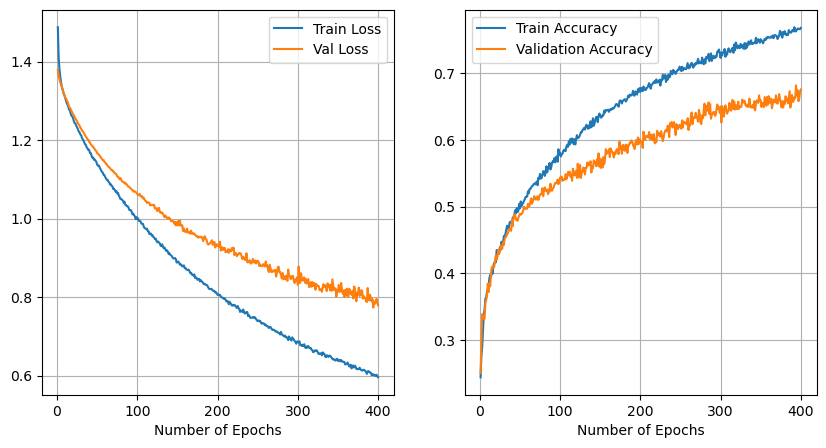

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, len(train_loss)+1), train_loss, 
           label='Train Loss');
ax[0].plot(range(1, len(val_loss)+1), 
         val_loss, label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[1].plot(range(1, len(train_accu)+1),train_accu,
          label = 'Train Accuracy')
ax[1].plot(range(1, len(val_accu)+1), val_accu, 
          label = 'Validation Accuracy')
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");
print(max(resnet50.history.history['val_accuracy']))

In [6]:
##reload the model if necessary
#resnet50 = tf.keras.models.load_model("./models/pretrained_resnet50")

In [128]:
resnet50.evaluate(normalized_val)

13/13 [==============================] - 9s 581ms/step - loss: 2.2677 - accuracy: 0.7175


[2.2676546573638916, 0.7174999713897705]

In [127]:
resnet50.load_weights("./models/resnet50_pretrained_onlytrain_dense")

2023-04-23 17:09:28.372109: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./models/resnet50_pretrained_onlytrain_dense: FAILED_PRECONDITION: models/resnet50_pretrained_onlytrain_dense; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [129]:
##free the last 4 convolutional layers and their batch norm layers
resnet50.layers[-7].trainable = True
resnet50.layers[-8].trainable = True
resnet50.layers[-10].trainable = True
resnet50.layers[-11].trainable= True

resnet50.layers[-13].trainable = True
resnet50.layers[-14].trainalbe = True
resnet50.layers[-17].trainable = True
resnet50.layers[-18].trainable = True

In [130]:
##recompile using smaller learning rate
# Compiling the model fine Tune
resnet50.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [131]:
#define early stopping
es = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=0)
##define automatic saving 
save = ModelCheckpoint(
    "./models/pretrained_resnet50_trainlast4convlayers",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
)

##fit 
%time
resnet50.fit(
  normalized_train,
  validation_data=normalized_val,
    epochs=50, callbacks=[es, save]  
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 24.3492 - accuracy: 0.3559
Epoch 1: val_accuracy improved from -inf to 0.24125, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:12:40.111770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:12:45.354264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 64s 1s/step - loss: 24.3492 - accuracy: 0.3559 - val_loss: 12.6285 - val_accuracy: 0.2412
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 7.3058 - accuracy: 0.4741
Epoch 2: val_accuracy improved from 0.24125 to 0.25438, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:13:38.051289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:13:43.657250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 58s 1s/step - loss: 7.3058 - accuracy: 0.4741 - val_loss: 17.1499 - val_accuracy: 0.2544
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 5.8248 - accuracy: 0.5261
Epoch 3: val_accuracy improved from 0.25438 to 0.28188, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:14:37.250438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:14:42.005890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 5.8248 - accuracy: 0.5261 - val_loss: 15.6763 - val_accuracy: 0.2819
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 5.0376 - accuracy: 0.5641
Epoch 4: val_accuracy improved from 0.28188 to 0.30125, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:15:35.337930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:15:41.003966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 58s 1s/step - loss: 5.0376 - accuracy: 0.5641 - val_loss: 12.4512 - val_accuracy: 0.3013
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 4.2654 - accuracy: 0.6095
Epoch 5: val_accuracy improved from 0.30125 to 0.35688, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:16:34.687689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:16:39.953525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 4.2654 - accuracy: 0.6095 - val_loss: 9.3785 - val_accuracy: 0.3569
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 3.8851 - accuracy: 0.6273
Epoch 6: val_accuracy improved from 0.35688 to 0.44188, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:17:33.805932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:17:39.112101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.8851 - accuracy: 0.6273 - val_loss: 6.1601 - val_accuracy: 0.4419
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 3.3184 - accuracy: 0.6633
Epoch 7: val_accuracy improved from 0.44188 to 0.53062, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:18:33.071650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:18:37.844085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.3184 - accuracy: 0.6633 - val_loss: 4.2688 - val_accuracy: 0.5306
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 3.0946 - accuracy: 0.6792
Epoch 8: val_accuracy improved from 0.53062 to 0.66938, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:19:31.476258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:19:37.136918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.0946 - accuracy: 0.6792 - val_loss: 3.1114 - val_accuracy: 0.6694
Epoch 9/50
50/50 [==============================] - ETA: 0s - loss: 2.7857 - accuracy: 0.7070
Epoch 9: val_accuracy improved from 0.66938 to 0.67375, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:20:31.211545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:20:36.543764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 2.7857 - accuracy: 0.7070 - val_loss: 2.9891 - val_accuracy: 0.6737
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 2.5907 - accuracy: 0.7356
Epoch 10: val_accuracy improved from 0.67375 to 0.71688, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:21:30.329871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:21:35.667005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 2.5907 - accuracy: 0.7356 - val_loss: 2.8344 - val_accuracy: 0.7169
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 2.4445 - accuracy: 0.7545
Epoch 11: val_accuracy did not improve from 0.71688
50/50 [==============================] - 43s 866ms/step - loss: 2.4445 - accuracy: 0.7545 - val_loss: 2.8136 - val_accuracy: 0.7069
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.7692
Epoch 12: val_accuracy did not improve from 0.71688
50/50 [==============================] - 44s 877ms/step - loss: 2.3017 - accuracy: 0.7692 - val_loss: 2.8609 - val_accuracy: 0.7094
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 2.1600 - accuracy: 0.7928
Epoch 13: val_accuracy improved from 0.71688 to 0.72750, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:23:57.407943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:24:02.184557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.1600 - accuracy: 0.7928 - val_loss: 2.7212 - val_accuracy: 0.7275
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 2.0861 - accuracy: 0.7983
Epoch 14: val_accuracy improved from 0.72750 to 0.73750, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:24:56.476678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:25:02.153117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 59s 1s/step - loss: 2.0861 - accuracy: 0.7983 - val_loss: 2.6895 - val_accuracy: 0.7375
Epoch 15/50
50/50 [==============================] - ETA: 0s - loss: 2.0156 - accuracy: 0.8156
Epoch 15: val_accuracy did not improve from 0.73750
50/50 [==============================] - 44s 872ms/step - loss: 2.0156 - accuracy: 0.8156 - val_loss: 2.6506 - val_accuracy: 0.7369
Epoch 16/50
50/50 [==============================] - ETA: 0s - loss: 1.9505 - accuracy: 0.8339
Epoch 16: val_accuracy did not improve from 0.73750
50/50 [==============================] - 44s 882ms/step - loss: 1.9505 - accuracy: 0.8339 - val_loss: 2.6289 - val_accuracy: 0.7287
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 1.8950 - accuracy: 0.8469
Epoch 17: val_accuracy did not improve from 0.73750
50/50 [==============================] - 44s 887ms/step - loss: 1.8950 - accuracy: 0.8469 - val_loss: 2.6473 - val_accuracy: 0.7250
Epoch 18/50
50/50 [===============

2023-04-23 17:28:09.264376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:28:14.551387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.8760 - accuracy: 0.8558 - val_loss: 2.6114 - val_accuracy: 0.7387
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 1.8380 - accuracy: 0.8680
Epoch 19: val_accuracy did not improve from 0.73875
50/50 [==============================] - 44s 880ms/step - loss: 1.8380 - accuracy: 0.8680 - val_loss: 2.8028 - val_accuracy: 0.7031
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 1.8154 - accuracy: 0.8777
Epoch 20: val_accuracy improved from 0.73875 to 0.74063, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:29:53.514647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:29:58.266731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.8154 - accuracy: 0.8777 - val_loss: 2.5878 - val_accuracy: 0.7406
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 1.7784 - accuracy: 0.8873
Epoch 21: val_accuracy did not improve from 0.74063
50/50 [==============================] - 44s 877ms/step - loss: 1.7784 - accuracy: 0.8873 - val_loss: 2.6779 - val_accuracy: 0.7163
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 1.7776 - accuracy: 0.8861
Epoch 22: val_accuracy improved from 0.74063 to 0.74313, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:31:37.820986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:31:42.613725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 61s 1s/step - loss: 1.7776 - accuracy: 0.8861 - val_loss: 2.6207 - val_accuracy: 0.7431
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.9005
Epoch 23: val_accuracy did not improve from 0.74313
50/50 [==============================] - 44s 876ms/step - loss: 1.7539 - accuracy: 0.9005 - val_loss: 2.6053 - val_accuracy: 0.7369
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 1.7310 - accuracy: 0.9031
Epoch 24: val_accuracy did not improve from 0.74313
50/50 [==============================] - 44s 885ms/step - loss: 1.7310 - accuracy: 0.9031 - val_loss: 2.6781 - val_accuracy: 0.7300
Epoch 25/50
50/50 [==============================] - ETA: 0s - loss: 1.7146 - accuracy: 0.9131
Epoch 25: val_accuracy did not improve from 0.74313
50/50 [==============================] - 44s 891ms/step - loss: 1.7146 - accuracy: 0.9131 - val_loss: 2.6809 - val_accuracy: 0.7406
Epoch 26/50
50/50 [===============

2023-04-23 17:36:19.066783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:36:24.738307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.6788 - accuracy: 0.9252 - val_loss: 2.5984 - val_accuracy: 0.7525
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 1.6748 - accuracy: 0.9222
Epoch 29: val_accuracy improved from 0.75250 to 0.75500, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:37:20.750416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:37:25.508863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 61s 1s/step - loss: 1.6748 - accuracy: 0.9222 - val_loss: 2.6194 - val_accuracy: 0.7550
Epoch 30/50
50/50 [==============================] - ETA: 0s - loss: 1.6510 - accuracy: 0.9336
Epoch 30: val_accuracy did not improve from 0.75500
50/50 [==============================] - 44s 874ms/step - loss: 1.6510 - accuracy: 0.9336 - val_loss: 2.6419 - val_accuracy: 0.7481
Epoch 31/50
50/50 [==============================] - ETA: 0s - loss: 1.6441 - accuracy: 0.9372
Epoch 31: val_accuracy did not improve from 0.75500
50/50 [==============================] - 44s 884ms/step - loss: 1.6441 - accuracy: 0.9372 - val_loss: 2.7198 - val_accuracy: 0.7362
Epoch 32/50
50/50 [==============================] - ETA: 0s - loss: 1.6491 - accuracy: 0.9328
Epoch 32: val_accuracy did not improve from 0.75500
50/50 [==============================] - 46s 931ms/step - loss: 1.6491 - accuracy: 0.9328 - val_loss: 2.6268 - val_accuracy: 0.7500
Epoch 33/50
50/50 [===============

2023-04-23 17:47:16.529032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:47:22.165131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.6018 - accuracy: 0.9438 - val_loss: 2.5937 - val_accuracy: 0.7744
Epoch 43/50
50/50 [==============================] - ETA: 0s - loss: 1.6136 - accuracy: 0.9398
Epoch 43: val_accuracy improved from 0.77438 to 0.77625, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:48:17.111756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:48:22.358971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.6136 - accuracy: 0.9398 - val_loss: 2.5598 - val_accuracy: 0.7763
Epoch 44/50
50/50 [==============================] - ETA: 0s - loss: 1.6501 - accuracy: 0.9212
Epoch 44: val_accuracy did not improve from 0.77625
50/50 [==============================] - 43s 865ms/step - loss: 1.6501 - accuracy: 0.9212 - val_loss: 2.7122 - val_accuracy: 0.7481
Epoch 45/50
50/50 [==============================] - ETA: 0s - loss: 1.7280 - accuracy: 0.8941
Epoch 45: val_accuracy did not improve from 0.77625
50/50 [==============================] - 44s 876ms/step - loss: 1.7280 - accuracy: 0.8941 - val_loss: 2.6840 - val_accuracy: 0.7300
Epoch 46/50
50/50 [==============================] - ETA: 0s - loss: 1.5911 - accuracy: 0.9489
Epoch 46: val_accuracy improved from 0.77625 to 0.77750, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:51:05.823115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:51:11.093019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.5911 - accuracy: 0.9489 - val_loss: 2.5125 - val_accuracy: 0.7775
Epoch 47/50
50/50 [==============================] - ETA: 0s - loss: 1.5840 - accuracy: 0.9498
Epoch 47: val_accuracy improved from 0.77750 to 0.77938, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:52:05.667451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:52:10.412605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.5840 - accuracy: 0.9498 - val_loss: 2.5612 - val_accuracy: 0.7794
Epoch 48/50
50/50 [==============================] - ETA: 0s - loss: 1.5732 - accuracy: 0.9567
Epoch 48: val_accuracy did not improve from 0.77938
50/50 [==============================] - 43s 871ms/step - loss: 1.5732 - accuracy: 0.9567 - val_loss: 2.5859 - val_accuracy: 0.7763
Epoch 49/50
50/50 [==============================] - ETA: 0s - loss: 1.5485 - accuracy: 0.9642
Epoch 49: val_accuracy did not improve from 0.77938
50/50 [==============================] - 44s 878ms/step - loss: 1.5485 - accuracy: 0.9642 - val_loss: 2.6030 - val_accuracy: 0.7788
Epoch 50/50
50/50 [==============================] - ETA: 0s - loss: 1.5245 - accuracy: 0.9722
Epoch 50: val_accuracy improved from 0.77938 to 0.78500, saving model to ./models/pretrained_resnet50_trainlast4convlayers


2023-04-23 17:54:32.396261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 17:54:38.028911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainlast4convlayers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.5245 - accuracy: 0.9722 - val_loss: 2.5890 - val_accuracy: 0.7850


In [110]:
resnet50.load_weights("./models/pretrained_resnet50_trainLastLayers")

2023-04-23 15:56:09.546378: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ./models/pretrained_resnet50_trainLastLayers: FAILED_PRECONDITION: models/pretrained_resnet50_trainLastLayers; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


0.7850000262260437


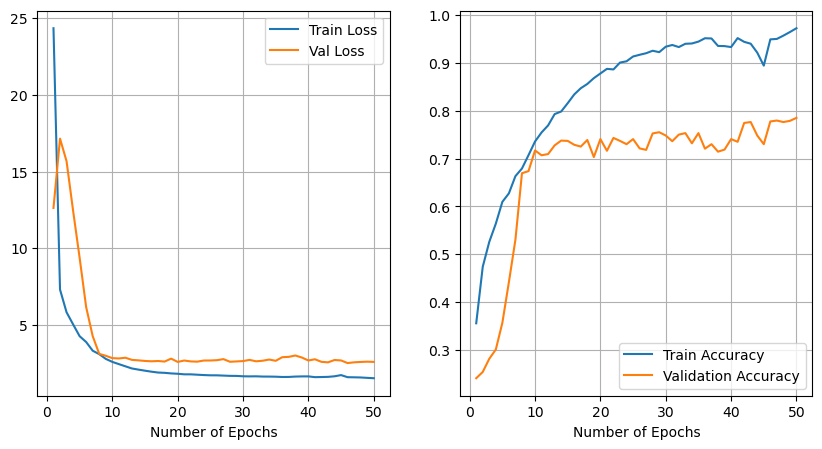

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, len(resnet50.history.history['loss'])+1), resnet50.history.history['loss'], 
           label='Train Loss');
ax[0].plot(range(1, len(resnet50.history.history['val_loss'])+1), 
         resnet50.history.history['val_loss'], label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[1].plot(range(1, len(resnet50.history.history['accuracy'])+1),resnet50.history.history['accuracy'],
          label = 'Train Accuracy')
ax[1].plot(range(1, len(resnet50.history.history['val_accuracy'])+1), resnet50.history.history['val_accuracy'], 
          label = 'Validation Accuracy')
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");
print(max(resnet50.history.history['val_accuracy']))

In [111]:
resnet50.evaluate(normalized_val)

13/13 [==============================] - 9s 581ms/step - loss: 2.4054 - accuracy: 0.7844


[2.405425786972046, 0.784375011920929]

Unfreeze more layers


In [94]:
resnet50.layers

In [112]:
resnet50.layers[-13].trainable = True
resnet50.layers[-14].trainalbe = True
resnet50.layers[-17].trainable = True
resnet50.layers[-18].trainable = True

In [113]:
##recompile using smaller learning rate
# Compiling the model fine Tune
resnet50.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=2e-6),
              metrics=['accuracy'])

In [114]:
#define early stopping
es = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=0)
##define automatic saving 
save = ModelCheckpoint(
    "./models/pretrained_resnet50_trainonlyLast2Layers",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
)

##fit 
%time
resnet50.fit(
  normalized_train,
  validation_data=normalized_val,
    epochs=60, callbacks=[es, save]  
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch 1/60
50/50 [==============================] - ETA: 0s - loss: 35.5596 - accuracy: 0.2998
Epoch 1: val_accuracy improved from -inf to 0.24062, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 15:59:28.294788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 15:59:33.562229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 63s 1s/step - loss: 35.5596 - accuracy: 0.2998 - val_loss: 33.9498 - val_accuracy: 0.2406
Epoch 2/60
50/50 [==============================] - ETA: 0s - loss: 8.9454 - accuracy: 0.4256
Epoch 2: val_accuracy improved from 0.24062 to 0.24688, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:00:26.258815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:00:31.485148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 58s 1s/step - loss: 8.9454 - accuracy: 0.4256 - val_loss: 30.0148 - val_accuracy: 0.2469
Epoch 3/60
50/50 [==============================] - ETA: 0s - loss: 6.7891 - accuracy: 0.4712
Epoch 3: val_accuracy improved from 0.24688 to 0.27250, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:01:24.611464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:01:29.395463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 6.7891 - accuracy: 0.4712 - val_loss: 19.4035 - val_accuracy: 0.2725
Epoch 4/60
50/50 [==============================] - ETA: 0s - loss: 5.9842 - accuracy: 0.4950
Epoch 4: val_accuracy improved from 0.27250 to 0.35688, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:02:23.422155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:02:28.139538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 5.9842 - accuracy: 0.4950 - val_loss: 11.2110 - val_accuracy: 0.3569
Epoch 5/60
50/50 [==============================] - ETA: 0s - loss: 5.2274 - accuracy: 0.5311
Epoch 5: val_accuracy improved from 0.35688 to 0.43875, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:03:22.271716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:03:27.037588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 5.2274 - accuracy: 0.5311 - val_loss: 7.2942 - val_accuracy: 0.4387
Epoch 6/60
50/50 [==============================] - ETA: 0s - loss: 4.8634 - accuracy: 0.5492
Epoch 6: val_accuracy improved from 0.43875 to 0.49437, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:04:20.474935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:04:26.058332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 58s 1s/step - loss: 4.8634 - accuracy: 0.5492 - val_loss: 5.4633 - val_accuracy: 0.4944
Epoch 7/60
50/50 [==============================] - ETA: 0s - loss: 4.5514 - accuracy: 0.5639
Epoch 7: val_accuracy improved from 0.49437 to 0.54438, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:05:19.788901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:05:25.012811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 4.5514 - accuracy: 0.5639 - val_loss: 4.5349 - val_accuracy: 0.5444
Epoch 8/60
50/50 [==============================] - ETA: 0s - loss: 4.3577 - accuracy: 0.5708
Epoch 8: val_accuracy improved from 0.54438 to 0.58312, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:06:18.797049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:06:24.024168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 4.3577 - accuracy: 0.5708 - val_loss: 4.0520 - val_accuracy: 0.5831
Epoch 9/60
50/50 [==============================] - ETA: 0s - loss: 4.1011 - accuracy: 0.5895
Epoch 9: val_accuracy improved from 0.58312 to 0.63000, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:07:17.890109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:07:23.142484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 4.1011 - accuracy: 0.5895 - val_loss: 3.8019 - val_accuracy: 0.6300
Epoch 10/60
50/50 [==============================] - ETA: 0s - loss: 3.8857 - accuracy: 0.5986
Epoch 10: val_accuracy improved from 0.63000 to 0.63813, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:08:19.171794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:08:23.934293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 61s 1s/step - loss: 3.8857 - accuracy: 0.5986 - val_loss: 3.7261 - val_accuracy: 0.6381
Epoch 11/60
50/50 [==============================] - ETA: 0s - loss: 3.7071 - accuracy: 0.6172
Epoch 11: val_accuracy improved from 0.63813 to 0.64750, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:09:18.381649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:09:23.176114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.7071 - accuracy: 0.6172 - val_loss: 3.6564 - val_accuracy: 0.6475
Epoch 12/60
50/50 [==============================] - ETA: 0s - loss: 3.5757 - accuracy: 0.6187
Epoch 12: val_accuracy did not improve from 0.64750
50/50 [==============================] - 43s 865ms/step - loss: 3.5757 - accuracy: 0.6187 - val_loss: 3.6001 - val_accuracy: 0.6463
Epoch 13/60
50/50 [==============================] - ETA: 0s - loss: 3.4647 - accuracy: 0.6291
Epoch 13: val_accuracy improved from 0.64750 to 0.65562, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:11:00.619332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:11:06.195399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.4647 - accuracy: 0.6291 - val_loss: 3.4957 - val_accuracy: 0.6556
Epoch 14/60
50/50 [==============================] - ETA: 0s - loss: 3.3163 - accuracy: 0.6392
Epoch 14: val_accuracy improved from 0.65562 to 0.66188, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:12:00.412189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:12:05.593087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.3163 - accuracy: 0.6392 - val_loss: 3.4429 - val_accuracy: 0.6619
Epoch 15/60
50/50 [==============================] - ETA: 0s - loss: 3.1741 - accuracy: 0.6505
Epoch 15: val_accuracy improved from 0.66188 to 0.67375, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:12:59.629997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:13:04.821698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 3.1741 - accuracy: 0.6505 - val_loss: 3.3338 - val_accuracy: 0.6737
Epoch 16/60
50/50 [==============================] - ETA: 0s - loss: 3.0855 - accuracy: 0.6609
Epoch 16: val_accuracy did not improve from 0.67375
50/50 [==============================] - 43s 868ms/step - loss: 3.0855 - accuracy: 0.6609 - val_loss: 3.3148 - val_accuracy: 0.6737
Epoch 17/60
50/50 [==============================] - ETA: 0s - loss: 3.0162 - accuracy: 0.6689
Epoch 17: val_accuracy did not improve from 0.67375
50/50 [==============================] - 44s 879ms/step - loss: 3.0162 - accuracy: 0.6689 - val_loss: 3.2635 - val_accuracy: 0.6725
Epoch 18/60
50/50 [==============================] - ETA: 0s - loss: 2.8891 - accuracy: 0.6747
Epoch 18: val_accuracy improved from 0.67375 to 0.68000, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:15:26.752433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:15:31.926617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.8891 - accuracy: 0.6747 - val_loss: 3.1905 - val_accuracy: 0.6800
Epoch 19/60
50/50 [==============================] - ETA: 0s - loss: 2.8621 - accuracy: 0.6828
Epoch 19: val_accuracy improved from 0.68000 to 0.68500, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:16:26.096461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:16:31.692744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 59s 1s/step - loss: 2.8621 - accuracy: 0.6828 - val_loss: 3.1558 - val_accuracy: 0.6850
Epoch 20/60
50/50 [==============================] - ETA: 0s - loss: 2.7431 - accuracy: 0.6891
Epoch 20: val_accuracy did not improve from 0.68500
50/50 [==============================] - 44s 873ms/step - loss: 2.7431 - accuracy: 0.6891 - val_loss: 3.1279 - val_accuracy: 0.6737
Epoch 21/60
50/50 [==============================] - ETA: 0s - loss: 2.6838 - accuracy: 0.6928
Epoch 21: val_accuracy did not improve from 0.68500
50/50 [==============================] - 44s 882ms/step - loss: 2.6838 - accuracy: 0.6928 - val_loss: 3.0934 - val_accuracy: 0.6806
Epoch 22/60
50/50 [==============================] - ETA: 0s - loss: 2.6236 - accuracy: 0.7083
Epoch 22: val_accuracy improved from 0.68500 to 0.68750, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:18:54.438803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:18:59.193220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.6236 - accuracy: 0.7083 - val_loss: 3.0375 - val_accuracy: 0.6875
Epoch 23/60
50/50 [==============================] - ETA: 0s - loss: 2.5920 - accuracy: 0.7080
Epoch 23: val_accuracy did not improve from 0.68750
50/50 [==============================] - 44s 877ms/step - loss: 2.5920 - accuracy: 0.7080 - val_loss: 3.0292 - val_accuracy: 0.6794
Epoch 24/60
50/50 [==============================] - ETA: 0s - loss: 2.5404 - accuracy: 0.7144
Epoch 24: val_accuracy did not improve from 0.68750
50/50 [==============================] - 44s 885ms/step - loss: 2.5404 - accuracy: 0.7144 - val_loss: 3.0125 - val_accuracy: 0.6850
Epoch 25/60
50/50 [==============================] - ETA: 0s - loss: 2.4651 - accuracy: 0.7258
Epoch 25: val_accuracy improved from 0.68750 to 0.69250, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:21:22.797845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:21:27.530886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.4651 - accuracy: 0.7258 - val_loss: 2.9600 - val_accuracy: 0.6925
Epoch 26/60
50/50 [==============================] - ETA: 0s - loss: 2.4099 - accuracy: 0.7386
Epoch 26: val_accuracy improved from 0.69250 to 0.69875, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:22:22.605773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:22:27.383052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.4099 - accuracy: 0.7386 - val_loss: 2.9300 - val_accuracy: 0.6988
Epoch 27/60
50/50 [==============================] - ETA: 0s - loss: 2.3642 - accuracy: 0.7450
Epoch 27: val_accuracy did not improve from 0.69875
50/50 [==============================] - 44s 873ms/step - loss: 2.3642 - accuracy: 0.7450 - val_loss: 2.9175 - val_accuracy: 0.6963
Epoch 28/60
50/50 [==============================] - ETA: 0s - loss: 2.3279 - accuracy: 0.7520
Epoch 28: val_accuracy did not improve from 0.69875
50/50 [==============================] - 44s 881ms/step - loss: 2.3279 - accuracy: 0.7520 - val_loss: 2.9081 - val_accuracy: 0.6975
Epoch 29/60
50/50 [==============================] - ETA: 0s - loss: 2.2868 - accuracy: 0.7577
Epoch 29: val_accuracy did not improve from 0.69875
50/50 [==============================] - 44s 887ms/step - loss: 2.2868 - accuracy: 0.7577 - val_loss: 2.8817 - val_accuracy: 0.6938
Epoch 30/60
50/50 [===============

2023-04-23 16:26:18.737900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:26:24.267969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.2191 - accuracy: 0.7695 - val_loss: 2.8165 - val_accuracy: 0.7075
Epoch 32/60
50/50 [==============================] - ETA: 0s - loss: 2.2247 - accuracy: 0.7694
Epoch 32: val_accuracy improved from 0.70750 to 0.71188, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:27:18.964627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:27:24.156382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.2247 - accuracy: 0.7694 - val_loss: 2.8036 - val_accuracy: 0.7119
Epoch 33/60
50/50 [==============================] - ETA: 0s - loss: 2.1615 - accuracy: 0.7789
Epoch 33: val_accuracy did not improve from 0.71188
50/50 [==============================] - 44s 875ms/step - loss: 2.1615 - accuracy: 0.7789 - val_loss: 2.8120 - val_accuracy: 0.7044
Epoch 34/60
50/50 [==============================] - ETA: 0s - loss: 2.1514 - accuracy: 0.7867
Epoch 34: val_accuracy improved from 0.71188 to 0.71438, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:29:02.531183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:29:07.777273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.1514 - accuracy: 0.7867 - val_loss: 2.7713 - val_accuracy: 0.7144
Epoch 35/60
50/50 [==============================] - ETA: 0s - loss: 2.1113 - accuracy: 0.7920
Epoch 35: val_accuracy did not improve from 0.71438
50/50 [==============================] - 44s 878ms/step - loss: 2.1113 - accuracy: 0.7920 - val_loss: 2.7757 - val_accuracy: 0.7119
Epoch 36/60
50/50 [==============================] - ETA: 0s - loss: 2.1031 - accuracy: 0.7948
Epoch 36: val_accuracy did not improve from 0.71438
50/50 [==============================] - 44s 885ms/step - loss: 2.1031 - accuracy: 0.7948 - val_loss: 2.7624 - val_accuracy: 0.7106
Epoch 37/60
50/50 [==============================] - ETA: 0s - loss: 2.0715 - accuracy: 0.7975
Epoch 37: val_accuracy improved from 0.71438 to 0.71938, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:31:30.841627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:31:36.123289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.0715 - accuracy: 0.7975 - val_loss: 2.7403 - val_accuracy: 0.7194
Epoch 38/60
50/50 [==============================] - ETA: 0s - loss: 2.0500 - accuracy: 0.8073
Epoch 38: val_accuracy improved from 0.71938 to 0.72250, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:32:30.708225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:32:35.456994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.0500 - accuracy: 0.8073 - val_loss: 2.7294 - val_accuracy: 0.7225
Epoch 39/60
50/50 [==============================] - ETA: 0s - loss: 2.0355 - accuracy: 0.8078
Epoch 39: val_accuracy did not improve from 0.72250
50/50 [==============================] - 44s 873ms/step - loss: 2.0355 - accuracy: 0.8078 - val_loss: 2.7206 - val_accuracy: 0.7212
Epoch 40/60
50/50 [==============================] - ETA: 0s - loss: 2.0148 - accuracy: 0.8164
Epoch 40: val_accuracy improved from 0.72250 to 0.72562, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:34:14.302865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:34:19.046528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 2.0148 - accuracy: 0.8164 - val_loss: 2.6955 - val_accuracy: 0.7256
Epoch 41/60
50/50 [==============================] - ETA: 0s - loss: 1.9971 - accuracy: 0.8202
Epoch 41: val_accuracy did not improve from 0.72562
50/50 [==============================] - 44s 875ms/step - loss: 1.9971 - accuracy: 0.8202 - val_loss: 2.6985 - val_accuracy: 0.7250
Epoch 42/60
50/50 [==============================] - ETA: 0s - loss: 1.9915 - accuracy: 0.8219
Epoch 42: val_accuracy did not improve from 0.72562
50/50 [==============================] - 44s 884ms/step - loss: 1.9915 - accuracy: 0.8219 - val_loss: 2.7052 - val_accuracy: 0.7225
Epoch 43/60
50/50 [==============================] - ETA: 0s - loss: 1.9716 - accuracy: 0.8253
Epoch 43: val_accuracy improved from 0.72562 to 0.73125, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:36:41.649933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:36:47.194427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.9716 - accuracy: 0.8253 - val_loss: 2.6782 - val_accuracy: 0.7312
Epoch 44/60
50/50 [==============================] - ETA: 0s - loss: 1.9499 - accuracy: 0.8358
Epoch 44: val_accuracy did not improve from 0.73125
50/50 [==============================] - 44s 880ms/step - loss: 1.9499 - accuracy: 0.8358 - val_loss: 2.6738 - val_accuracy: 0.7262
Epoch 45/60
50/50 [==============================] - ETA: 0s - loss: 1.9416 - accuracy: 0.8442
Epoch 45: val_accuracy did not improve from 0.73125
50/50 [==============================] - 44s 887ms/step - loss: 1.9416 - accuracy: 0.8442 - val_loss: 2.6695 - val_accuracy: 0.7312
Epoch 46/60
50/50 [==============================] - ETA: 0s - loss: 1.9277 - accuracy: 0.8428
Epoch 46: val_accuracy improved from 0.73125 to 0.73500, saving model to ./models/pretrained_resnet50_trainonlyLast2Layers


2023-04-23 16:39:10.495792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:39:15.661600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 61s 1s/step - loss: 1.9277 - accuracy: 0.8428 - val_loss: 2.6423 - val_accuracy: 0.7350
Epoch 47/60
50/50 [==============================] - ETA: 0s - loss: 1.9180 - accuracy: 0.8472
Epoch 47: val_accuracy did not improve from 0.73500
50/50 [==============================] - 44s 880ms/step - loss: 1.9180 - accuracy: 0.8472 - val_loss: 2.6738 - val_accuracy: 0.7188
Epoch 48/60
50/50 [==============================] - ETA: 0s - loss: 1.9068 - accuracy: 0.8472
Epoch 48: val_accuracy did not improve from 0.73500
50/50 [==============================] - 44s 879ms/step - loss: 1.9068 - accuracy: 0.8472 - val_loss: 2.7062 - val_accuracy: 0.7206
Epoch 49/60
50/50 [==============================] - ETA: 0s - loss: 1.9015 - accuracy: 0.8528
Epoch 49: val_accuracy did not improve from 0.73500
50/50 [==============================] - 44s 886ms/step - loss: 1.9015 - accuracy: 0.8528 - val_loss: 2.6683 - val_accuracy: 0.7312
Epoch 50/60
50/50 [===============

2023-04-23 16:42:22.216757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:42:27.741716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 60s 1s/step - loss: 1.8739 - accuracy: 0.8612 - val_loss: 2.6330 - val_accuracy: 0.7437
Epoch 51/60
50/50 [==============================] - ETA: 0s - loss: 1.8701 - accuracy: 0.8619
Epoch 51: val_accuracy did not improve from 0.74375
50/50 [==============================] - 44s 873ms/step - loss: 1.8701 - accuracy: 0.8619 - val_loss: 2.6532 - val_accuracy: 0.7337
Epoch 52/60
50/50 [==============================] - ETA: 0s - loss: 1.8569 - accuracy: 0.8664
Epoch 52: val_accuracy did not improve from 0.74375
50/50 [==============================] - 44s 880ms/step - loss: 1.8569 - accuracy: 0.8664 - val_loss: 2.6421 - val_accuracy: 0.7406
Epoch 53/60
50/50 [==============================] - ETA: 0s - loss: 1.8542 - accuracy: 0.8739
Epoch 53: val_accuracy did not improve from 0.74375
50/50 [==============================] - 45s 893ms/step - loss: 1.8542 - accuracy: 0.8739 - val_loss: 2.6434 - val_accuracy: 0.7375
Epoch 54/60
50/50 [===============

2023-04-23 16:49:18.530077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-04-23 16:49:23.744475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


INFO:tensorflow:Assets written to: ./models/pretrained_resnet50_trainonlyLast2Layers/assets


50/50 [==============================] - 61s 1s/step - loss: 1.7985 - accuracy: 0.8902 - val_loss: 2.6334 - val_accuracy: 0.7462
Epoch 60/60
50/50 [==============================] - ETA: 0s - loss: 1.7963 - accuracy: 0.8941
Epoch 60: val_accuracy did not improve from 0.74625
50/50 [==============================] - 44s 884ms/step - loss: 1.7963 - accuracy: 0.8941 - val_loss: 2.6676 - val_accuracy: 0.7431


0.7462499737739563


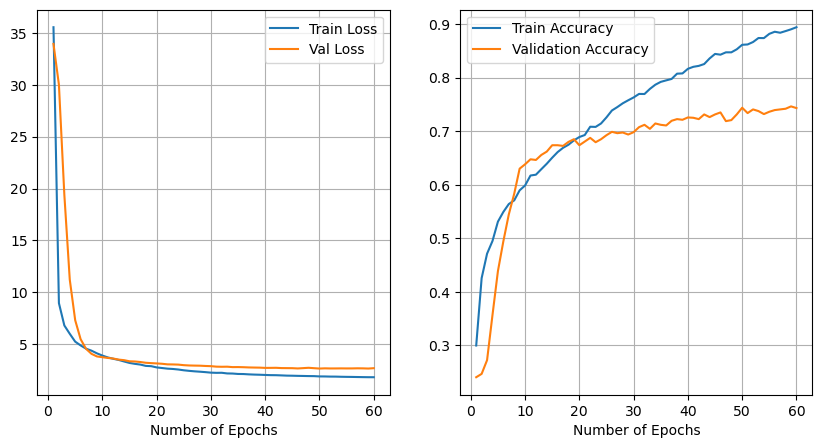

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, len(resnet50.history.history['loss'])+1), resnet50.history.history['loss'], 
           label='Train Loss');
ax[0].plot(range(1, len(resnet50.history.history['val_loss'])+1), 
         resnet50.history.history['val_loss'], label='Val Loss');
ax[0].grid();
ax[0].legend();
ax[0].set_xlabel("Number of Epochs");
ax[1].plot(range(1, len(resnet50.history.history['accuracy'])+1),resnet50.history.history['accuracy'],
          label = 'Train Accuracy')
ax[1].plot(range(1, len(resnet50.history.history['val_accuracy'])+1), resnet50.history.history['val_accuracy'], 
          label = 'Validation Accuracy')
ax[1].grid();
ax[1].legend();
ax[1].set_xlabel("Number of Epochs");
print(max(resnet50.history.history['val_accuracy']))

In [121]:
resnet50.evaluate(normalized_val)

13/13 [==============================] - 8s 583ms/step - loss: 2.6676 - accuracy: 0.7431


[2.667616367340088, 0.7431250214576721]

## Load Test Images

In [116]:
##load the test image
testset1 = utils.image_dataset_from_directory(
    './test/class1',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset2 = utils.image_dataset_from_directory(
    './test/class2',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

testset3 = utils.image_dataset_from_directory(
    './test/class3',
    labels=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(258, 347),
    shuffle=False,
    seed=109,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

##normalize the testset
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_testset1 = testset1.map(lambda x: normalization_layer(x))
normalized_testset2 = testset2.map(lambda x: normalization_layer(x))
normalized_testset3 = testset3.map(lambda x: normalization_layer(x))

Found 1800 files belonging to 1 classes.
Found 1414 files belonging to 1 classes.
Found 1800 files belonging to 1 classes.


In [117]:
##predict
prediction1 = np.array([x.argmax() for x in resnet50.predict(normalized_testset1)])
prediction2 = np.array([x.argmax() for x in resnet50.predict(normalized_testset2)]) 
prediction3 = np.array([x.argmax() for x in resnet50.predict(normalized_testset3)])

2023-04-23 17:06:11.814042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-23 17:06:11.814367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 10s 333ms/step


2023-04-23 17:06:22.292126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]
2023-04-23 17:06:22.292431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1414]
	 [[{{node Placeholder/_0}}]]


 1/29 [>.............................] - ETA: 5s

2023-04-23 17:06:29.881351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]
2023-04-23 17:06:29.881672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1800]
	 [[{{node Placeholder/_0}}]]


29/29 [==============================] - 9s 306ms/step


In [118]:
print(np.unique(prediction1))
print("Number of prediction 0: {}".format((prediction1==0).sum()))
print("Number of prediction 1: {}".format((prediction1==1).sum()))
print("Number of prediction 2: {}".format((prediction1==2).sum()))
print("Number of prediction 3: {}".format((prediction1==3).sum()))

[0]
Number of prediction 0: 1800
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 0


In [119]:
print(np.unique(prediction2))
print("Number of prediction 0: {}".format((prediction2==0).sum()))
print("Number of prediction 1: {}".format((prediction2==1).sum()))
print("Number of prediction 2: {}".format((prediction2==2).sum()))
print("Number of prediction 3: {}".format((prediction2==3).sum()))

[0 3]
Number of prediction 0: 1356
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 58


In [120]:
print(np.unique(prediction3))
print("Number of prediction 0: {}".format((prediction3==0).sum()))
print("Number of prediction 1: {}".format((prediction3==1).sum()))
print("Number of prediction 2: {}".format((prediction3==2).sum()))
print("Number of prediction 3: {}".format((prediction3==3).sum()))

[0 3]
Number of prediction 0: 1795
Number of prediction 1: 0
Number of prediction 2: 0
Number of prediction 3: 5
